In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Padding

In [2]:
def pad_with_zeros(X, n_pads):
    """
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    n_pads -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_padded -- padded image of shape (m, n_H + 2 * n_pads, n_W + 2 * n_pads, n_C)
    """

    X_padded = np.pad(X, ((0,0), (n_pads,n_pads), (n_pads,n_pads), (0,0)), mode='constant', constant_values = (0,0))
    return X_padded

x.shape = (1, 3, 3, 3)
x_padded.shape = (1, 9, 9, 3)


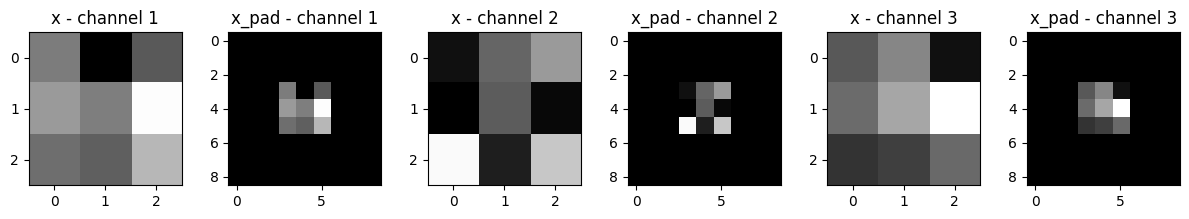

In [3]:
x = np.random.rand(1, 3, 3, 3)
x = (x - np.min(x)) / (np.max(x) - np.min(x))
x_padded = pad_with_zeros(x, n_pads=3)

print('x.shape =', x.shape)
print('x_padded.shape =', x_padded.shape)

fig, axes = plt.subplots(1, 6, figsize=(12, 8))
axes = axes.flatten()  # Flatten the 2D array of axes

for i in range(3):
    axes[i*2].set_title(f'x - channel {i+1}')
    axes[i*2].imshow(x[0, :, :, i], cmap='gray', vmin=0, vmax=1)
    
    axes[i*2+1].set_title(f'x_pad - channel {i+1}')
    axes[i*2+1].imshow(x_padded[0, :, :, i], cmap='gray', vmin=0, vmax=1)

plt.tight_layout()
plt.show()

# Forward Pass of Conv_Layer

In [4]:
def convolute(a_sliced_prev, w, b):
    """
    Arguments:
    a_sliced_prev -- slice of input data of shape (f, f, n_C_prev)
    w -- Weights in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias in a window - matrix of shape (1, 1, 1)
    
    Returns:
    z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """

    z = np.sum(a_sliced_prev * w) + b.item()  # Extract the scalar value from the array b
    return z

In [5]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
w = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

z = convolute(a_slice_prev, w, b)
print("Z =", z)

Z = -6.999089450680221


The formulas relating the output shape of the convolution to the input shape are:
    
$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{number of filters used in the convolution}$$
    



For this exercise, don't worry about vectorization! Just implement everything with for-loops.

In [6]:
def forward_conv(A_prev, W, B, padding, strides):
    """
    Arguments:
    A_prev -- output of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f_H, f_W, n_C_prev, n_C)
    B -- Biases, numpy array of shape (1, 1, 1, n_C)
    padding -- int, the amount of zero-padding to add around the border
    strides -- tuple of two ints, (stride_h, stride_w), the strides for height and width
    
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the backward_conv() function
    """
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    f_H, f_W, _, n_C = W.shape
    stride_H, stride_W = strides
    
    n_H = int((n_H_prev - f_H + 2*padding) / stride_H) + 1
    n_W = int((n_W_prev - f_W + 2*padding) / stride_W) + 1

    A_prev_padded = pad_with_zeros(A_prev, n_pads=padding)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        a_prev = A_prev_padded[i]  # Take 1 sample
        
        for h in range(n_H):  # Loop over output height
            start_H = h * stride_H
            end_H = start_H + f_H

            for w in range(n_W):  # Loop over output width
                start_W = w * stride_W
                end_W = start_W + f_W

                for c in range(n_C):  # Loop over the number of channels
                    a_sliced_prev = a_prev[start_H:end_H, start_W:end_W, :]  # Take a slice across 3D of 1 sample
                
                    Z[i, h, w, c] = convolute(a_sliced_prev, W[..., c], B[..., c])

    cache_conv = (A_prev, W, B, padding, strides)
    return Z, cache_conv

In [7]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
B = np.random.randn(1, 1, 1, 8)

padding = 1
strides = (2,2)

Z, cache_conv = forward_conv(A_prev, W, B, padding, strides)
print('Z.shape =', Z.shape)
Z[0, 2, 1], cache_conv[0][1][2][3]

Z.shape = (2, 3, 4, 8)


(array([-2.17796037,  8.07171329, -0.5772704 ,  3.36286738,  4.48113645,
        -2.89198428, 10.99288867,  3.03171932]),
 array([-1.1191154 ,  1.9560789 , -0.3264995 , -1.34267579]))

# Forward Pass of Pooling Layer

As there's no padding, the formulas binding the output shape of the pooling to the input shape is:

$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - p}{stride} \Bigr\rfloor +1$$

$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - p}{stride} \Bigr\rfloor +1$$

$$n_C = n_{C_{prev}}$$

In [8]:
def forward_pool(A_prev, pool_size, strides, mode='max'):
    """
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    pool_size -- tuple of two ints, (f_H, f_W), size of the pooling window
    strides -- tuple of two ints, (stride_H, stride_W), the stride for height and width
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pooling layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache_pool -- cache of values needed for the backward pass of the pooling layer, contains the layer's input and hyperparameters
    """
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    p_H, p_W = pool_size
    stride_H, stride_W = strides

    n_H = int((n_H_prev - p_H) / stride_H) + 1
    n_W = int((n_W_prev - p_W) / stride_W) + 1
    n_C = n_C_prev

    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        a_prev = A_prev[i]

        for h in range(n_H):
            start_H = h * stride_H
            end_H = start_H + p_H

            for w in range(n_W):
                start_W = w * stride_W
                end_W = start_W + p_W

                for c in range(n_C):
                    a_sliced_prev = a_prev[start_H:end_H, start_W:end_W, c]  # Take a slice of 1 channel of 1 sample
              
                    if mode == 'max':
                        A[i, h, w, c] = np.max(a_sliced_prev)
                    elif mode == 'average':
                        A[i, h, w, c] = np.mean(a_sliced_prev)

    cache_pool = (A_prev, pool_size, strides)
    return A, cache_pool

In [9]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)

pool_size = (3,3)
strides = (1,1)

A_max, _ = forward_pool(A_prev, pool_size, strides, mode='max')
A_average, _ = forward_pool(A_prev, pool_size, strides, mode='average')
print('A_max.shape =', A_max.shape)
print('A_average.shape =', A_average.shape)
A_max[1,1], A_average[1,1]

A_max.shape = (2, 3, 3, 3)
A_average.shape = (2, 3, 3, 3)


(array([[1.96710175, 0.84616065, 1.27375593],
        [1.96710175, 0.84616065, 1.23616403],
        [1.62765075, 1.12141771, 1.2245077 ]]),
 array([[ 0.44497696, -0.00261695, -0.31040307],
        [ 0.50811474, -0.23493734, -0.23961183],
        [ 0.11872677,  0.17255229, -0.22112197]]))

In [10]:
# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)

pool_size = (3,3)
strides = (2,2)

A_max, _ = forward_pool(A_prev, pool_size, strides, mode='max')
A_average, _ = forward_pool(A_prev, pool_size, strides, mode='average')
print('A_max.shape =', A_max.shape)
print('A_average.shape =', A_average.shape)
A_max[0], A_average[1]

A_max.shape = (2, 2, 2, 3)
A_average.shape = (2, 2, 2, 3)


(array([[[1.74481176, 0.90159072, 1.65980218],
         [1.74481176, 1.6924546 , 1.65980218]],
 
        [[1.13162939, 1.51981682, 2.18557541],
         [1.13162939, 1.6924546 , 2.18557541]]]),
 array([[[-0.17313416,  0.32377198, -0.34317572],
         [ 0.02030094,  0.14141479, -0.01231585]],
 
        [[ 0.42944926,  0.08446996, -0.27290905],
         [ 0.15077452,  0.28911175,  0.00123239]]]))

**What you should remember**:

* A convolution extracts features from an input image by taking the dot product between the input data and a 3D array of weights (the filter). 
* The 2D output of the convolution is called the feature map
* A convolution layer is where the filter slides over the image and computes the dot product 
    * This transforms the input volume into an output volume of different size 
* Zero padding helps keep more information at the image borders, and is helpful for building deeper networks, because you can build a CONV layer without shrinking the height and width of the volumes
* Pooling layers gradually reduce the height and width of the input by sliding a 2D window over each specified region, then summarizing the features in that region

# Backpropagation of Conv_Layer

https://www.youtube.com/watch?v=z9hJzduHToc

In [11]:
def backward_conv(dZ, cache_conv):
    """
    Arguments:
    dZ -- Gradient of the cost w.r.t the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache_conv -- Cache of values needed for backward propagation (A_prev, W, B, padding, strides)
    
    Returns:
    dA_prev -- Gradient of the cost w.r.t the input of the conv layer (A_prev), numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- Gradient of the cost w.r.t the weights (W), numpy array of shape (f_H, f_W, n_C_prev, n_C)
    dB -- Gradient of the cost w.r.t the biases (B), numpy array of shape (1, 1, 1, n_C)
    """    
    A_prev, W, B, padding, strides = cache_conv
    stride_H, stride_W = strides
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    f_H, f_W, _, n_C = W.shape
    _, n_H, n_W, _ = dZ.shape

    dA_prev = np.zeros(A_prev.shape)  # without padding
    dW = np.zeros(W.shape)
    dB = np.zeros((1, 1, 1, n_C))

    A_prev_padded = pad_with_zeros(A_prev, n_pads=padding)
    dA_prev_padded = pad_with_zeros(dA_prev, n_pads=padding)

    for i in range(m):
        a_prev = A_prev_padded[i]
        da_prev = dA_prev_padded[i]
        
        for h in range(n_H):
            start_H = h * stride_H
            end_H = start_H + f_H
    
            for w in range(n_W):
                start_W = w * stride_W
                end_W = start_W + f_W
    
                for c in range(n_C):
                    a_sliced_prev = a_prev[start_H:end_H, start_W:end_W, :]

                    da_prev[start_H:end_H, start_W:end_W, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_sliced_prev * dZ[i, h, w, c]
                    dB[:, :, :, c] += dZ[i, h, w, c]

        if padding != 0:  # remove padding
            dA_prev[i, :, :, :] = da_prev[padding:-padding, padding:-padding, :]
        else:
            dA_prev[i, :, :, :] = da_prev
        
    return dA_prev, dW, dB

In [12]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
B = np.random.randn(1, 1, 1, 8)

padding = 2
strides = (2,2)

Z, cache_conv = forward_conv(A_prev, W, B, padding, strides)
dA_prev, dW, dB = backward_conv(Z, cache_conv)

print("dA_prev_mean =", np.mean(dA_prev))
print("dW_mean =", np.mean(dW))
print("dB_mean =", np.mean(dB))

dA_prev_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
dB_mean = 7.839232564616838


**Expected Output**:
<table>
    <tr>
        <td>
            dA_mean
        </td>
        <td>
            1.45243777754
        </td>
    </tr>
    <tr>
        <td>
            dW_mean
        </td>
        <td>
            1.72699145831
        </td>
    </tr>
    <tr>
        <td>
            db_mean
        </td>
        <td>
            7.83923256462
        </td>
    </tr>

</table>


# Backpropagation of Pooling Layer

### Helper Function for Max Pooling Backprop

Before jumping into the backpropagation of the pooling layer, you are going to build a helper function which does the following: 

$$ A_{prev} = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow \quad mask\_maxPool =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}$$

As you can see, this function creates a "mask" matrix which keeps track of where the maximum of the matrix is. True (1) indicates the position of the maximum in X, the other entries are False (0). You'll see later that the backward pass for average pooling is similar to this, but uses a different mask.  

### Helper Function for Average Pooling Backprop

In max pooling, for each input window, all the "influence" on the output came from a single input value - the max value. In average pooling, every element of the input window has equal influence on the output. So to implement backprop, you will now implement a helper function that reflects this.

For example if we did average pooling in the forward pass using a 2x2 filter, then the mask you'll use for the backward pass will look like: 
$$ A_{prev} = \begin{bmatrix}
a && b \\
c && d
\end{bmatrix} \quad \rightarrow \quad mask\_avgPool =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}$$

This implies that each position in the `A_prev` matrix contributes equally to output because in the forward pass, we took an average. 

In [13]:
def backward_pool(dA, cache_pool, mode='max'):
    A_prev, pool_size, strides = cache_pool
    p_H, p_W = pool_size
    stride_H, stride_W = strides

    m, n_H_prev, n_W_prev, n_C = A_prev.shape
    _, n_H, n_W, _ = dA.shape

    dA_prev = np.zeros(A_prev.shape)

    for i in range(m):
        a_prev = A_prev[i, :, :, :]
        da_prev = dA_prev[i, :, :, :]
        
        for h in range(n_H):
            start_H = h * stride_H
            end_H = start_H + p_H
    
            for w in range(n_W):
                start_W = w * stride_W
                end_W = start_W + p_W
    
                for c in range(n_C):

                    if mode == 'max':
                        a_sliced_prev = a_prev[start_H:end_H, start_W:end_W, c]
                        mask_maxPool = (a_sliced_prev == np.max(a_sliced_prev)).astype(int)  # mask == dA w.r.t dA_prev
                        da_prev[start_H:end_H, start_W:end_W, c] += mask_maxPool * dA[i, h, w, c]
                        
                    elif mode == 'average':
                        mask_avgPool = np.ones(pool_size) / np.prod(pool_size)  # mask == dA w.r.t dA_prev
                        da_prev[start_H:end_H, start_W:end_W, c] += mask_avgPool * dA[i, h, w, c]
    return dA_prev

In [14]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
pool_size = (2,2)
strides = (1,1)

A, cache_pool = forward_pool(A_prev, pool_size, strides)
print(A.shape)
print(cache_pool[0].shape)

dA = np.random.randn(5, 4, 2, 2)
dA_prev_max = backward_pool(dA, cache_pool, mode="max")
dA_prev_avg = backward_pool(dA, cache_pool, mode="average")

np.mean(dA), dA_prev_max[1, 1], dA_prev_avg[1, 1]

(5, 4, 2, 2)
(5, 5, 3, 2)


(0.14571390272918056,
 array([[ 0.        ,  0.        ],
        [ 5.05844394, -1.68282702],
        [ 0.        ,  0.        ]]),
 array([[ 0.08485462,  0.2787552 ],
        [ 1.26461098, -0.25749373],
        [ 1.17975636, -0.53624893]]))

**Expected Output**: 

`mode = max`
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
dA_prev[1,1] =
</td>
<td>
[[ 0.          0.        ] <br>
 [ 5.05844394 -1.68282702] <br>
 [ 0.          0.        ]]
</td>
</tr>
</table>

`mode = average`
<table> 
<tr> 
<td>

mean of dA =
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
dA_prev[1,1] =
</td>
<td>
[[ 0.08485462  0.2787552 ] <br>
 [ 1.26461098 -0.25749373] <br>
 [ 1.17975636 -0.53624893]]
</td>
</tr>
</table>